In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device # 这里是设置跑程序采用CPU还是GPU

device(type='cuda')

In [3]:
train_data = torchvision.datasets.MNIST('data',train=True,transform=torchvision.transforms.ToTensor(),download=False)

In [4]:
test_data = torchvision.datasets.MNIST('data',train=False,transform=torchvision.transforms.ToTensor(),download=False)

In [5]:
img,target = train_data[0]

In [6]:
img.shape

torch.Size([1, 28, 28])

In [7]:
batch_size = 32
train_data = torch.utils.data.DataLoader(train_data,batch_size =batch_size,shuffle=True)
test_data = torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [8]:
imgs, labels = next(iter(train_data))
imgs.shape

torch.Size([32, 1, 28, 28])

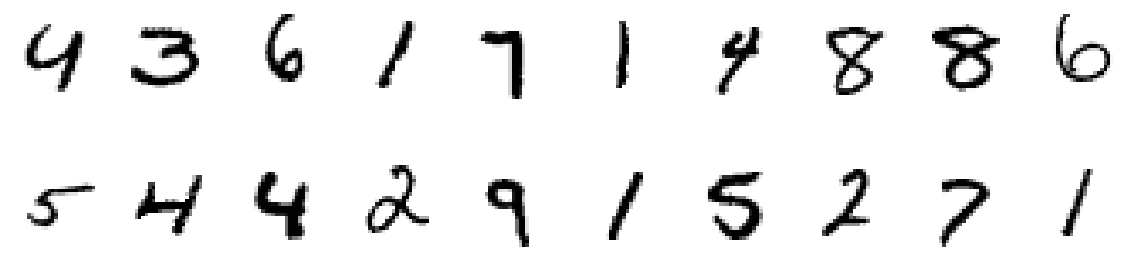

In [9]:
import numpy as np
 # 指定图片大小，图像大小为20宽、5高的绘图(单位为英寸inch)
plt.figure(figsize=(20, 5)) 
for i, imgs in enumerate(imgs[:20]):
    # 维度缩减
    npimg = np.squeeze(imgs.numpy())
    # 将整个figure分成2行10列，绘制第i+1个子图。
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg, cmap=plt.cm.binary)
    plt.axis('off')

# 构建简单的CNN网络

In [10]:
import torch.nn.functional as F

In [11]:
num_classes = 10

In [12]:
class Model(nn.Module):
     def __init__(self):
        super().__init__()
         # 特征提取网络
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 第一层卷积,卷积核大小为3*3
        self.pool1 = nn.MaxPool2d(2)                  # 设置池化层，池化核大小为2*2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # 第二层卷积,卷积核大小为3*3   
        self.pool2 = nn.MaxPool2d(2) 
                                      
        # 分类网络
        self.fc1 = nn.Linear(1600, 64)          
        self.fc2 = nn.Linear(64, num_classes)
     # 前向传播
     def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))     
        x = self.pool2(F.relu(self.conv2(x)))

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       
        return x

In [13]:
from torchinfo import summary
# 将模型转移到GPU中（我们模型运行均在GPU中进行）
model = Model().to(device)

summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Conv2d: 1-1                            320
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            102,464
├─Linear: 1-6                            650
Total params: 121,930
Trainable params: 121,930
Non-trainable params: 0

In [14]:
loss_fn = nn.CrossEntropyLoss() # 创建损失函数
learn_rate = 1e-2
opt = torch.optim.SGD(model.parameters(),lr=learn_rate)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小，一共60000张图片
    num_batches = len(dataloader)   # 批次数目，1875（60000/32）

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [16]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [17]:
epochs     = 5
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_data, model, loss_fn, opt)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_data, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print('Done')

Epoch: 1, Train_acc:74.7%, Train_loss:0.867, Test_acc:91.5%，Test_loss:0.286
Epoch: 2, Train_acc:93.8%, Train_loss:0.203, Test_acc:96.1%，Test_loss:0.133
Epoch: 3, Train_acc:96.2%, Train_loss:0.126, Test_acc:97.2%，Test_loss:0.092
Epoch: 4, Train_acc:97.1%, Train_loss:0.094, Test_acc:97.6%，Test_loss:0.075
Epoch: 5, Train_acc:97.6%, Train_loss:0.079, Test_acc:97.9%，Test_loss:0.065
Done
